## Computer Vision PA #2: Structure from Motion (SfM)
20195003 고강빈

In [37]:
import numpy as np
import cv2 as cv

import os
import glob

import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath("./SfM/Step2")  # 'calibrated_fivepoint.m'가 위치한 경로

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [38]:
MAXITER = 100
threshold = 5e-4

# intrinsic parameter
K = np.array([[3451.5, 0.0, 2312.0], [0.0, 3451.5, 1734], [0.0,0.0,1.0]])
K_inv = np.linalg.inv(K)

In [39]:
################################################################################################################################
# Step 1: Feature Extraction & Matching
################################################################################################################################
img1 = cv.imread('./SfM/Data/sfm03.jpg')
img2 = cv.imread('./SfM/Data/sfm04.jpg')

# create SIFT instance
sift = cv.SIFT_create()
# sift = cv.xfeatures2d.SIFT_create()

# detect and compute keypoints
img1_kp, img1_des = sift.detectAndCompute(img1, None)
img2_kp, img2_des = sift.detectAndCompute(img2, None)

# KNN matching with k=2
bf = cv.BFMatcher()
matches = bf.knnMatch(img1_des, img2_des, k=2)

# Ratio test
good = [m1 for m1, m2 in matches if m1.distance < 0.8 * m2.distance]
sorted_good = sorted(good, key=lambda x: x.distance)

print(f'# of matches: {len(sorted_good)}')

# save result as image
# img1_drawKps = cv.drawKeypoints(img1, img1_kp, None)
# img2_drawKps = cv.drawKeypoints(img2, img2_kp, None)
# cv.imwrite('./results/sift_keypoints.jpg',img1_drawKps)
# print('save keypoints: done')

# res = cv.drawMatches(img1, img1_kp, img2, img2_kp, sorted_good, img2, flags=2) 
# cv.imwrite('./results/sift_bfMatcher.jpg',res)
# print('save matches: done')

# of matches: 2592
save keypoints: done
save matches: done


In [40]:
################################################################################################################################
# Step 2: Essential Matrix Estimation
################################################################################################################################
query_idx = [good.queryIdx for good in sorted_good]
train_idx = [good.trainIdx for good in sorted_good]

kp1 = np.float32([img1_kp[idx].pt for idx in query_idx])
kp2 = np.float32([img2_kp[idx].pt for idx in train_idx])

ones = np.ones((1, len(kp1)))

q1 = np.append(kp1.T, ones, axis=0)
q2 = np.append(kp2.T, ones, axis=0)

norm_q1 = K_inv @ q1
norm_q2 = K_inv @ q2

best_in = 0
best_E = None

# 5-points algorithm / RANSAC
for _ in tqdm(range(MAXITER)):

    idx = np.random.randint(0, len(kp1), size=5)
    rand_norm_q1 = norm_q1[:, idx]
    rand_norm_q2 = norm_q2[:, idx]
    rand_norm_q1_doub = matlab.double(rand_norm_q1.tolist())
    rand_norm_q2_doub = matlab.double(rand_norm_q2.tolist())
    
    E = eng.calibrated_fivepoint(rand_norm_q1_doub, rand_norm_q2_doub)
    E = np.array(E)
    
    for i in range(E.shape[1]):
        cur_E = E[:,i].reshape(3,3)
        
        estim = np.diag(norm_q2.T @ cur_E @ norm_q1)
        cur_in = sum(np.where(((estim < threshold) & (estim >= 0)), True, False))
        if best_in < cur_in:
            best_in = cur_in
            best_E = cur_E
            inlier_idx = np.where(((estim < threshold) & (estim >= 0)))

print(f'# of inliers: {best_in}')
inlier_idx = np.array(inlier_idx).reshape(-1)

# save
df = pd.DataFrame(best_E)
df.to_csv('./results/EssentialMatrix.csv')
print('save Essential Matrix: done')

100%|██████████| 100/100 [00:05<00:00, 19.92it/s]

# of inliers: 1111
save Essential Matrix: done


candidate for camera matrix
 [[[ 0.63278308  0.163558   -0.75685821  0.83786391]
  [ 0.12153432 -0.98630138 -0.11153029  0.1379117 ]
  [-0.76473197 -0.02140977 -0.64399273 -0.52817084]]

 [[ 0.63278308  0.163558   -0.75685821 -0.83786391]
  [ 0.12153432 -0.98630138 -0.11153029 -0.1379117 ]
  [-0.76473197 -0.02140977 -0.64399273  0.52817084]]

 [[ 0.96059316 -0.14290489  0.23840927  0.83786391]
  [ 0.14073408  0.98970086  0.02619403  0.1379117 ]
  [-0.23969712  0.0083905   0.97081146 -0.52817084]]

 [[ 0.96059316 -0.14290489  0.23840927 -0.83786391]
  [ 0.14073408  0.98970086  0.02619403 -0.1379117 ]
  [-0.23969712  0.0083905   0.97081146  0.52817084]]]
Matrix 0 is not good
Matrix 1 is not good
Matrix 2 is not good
Matrix 3 have all positive depths!


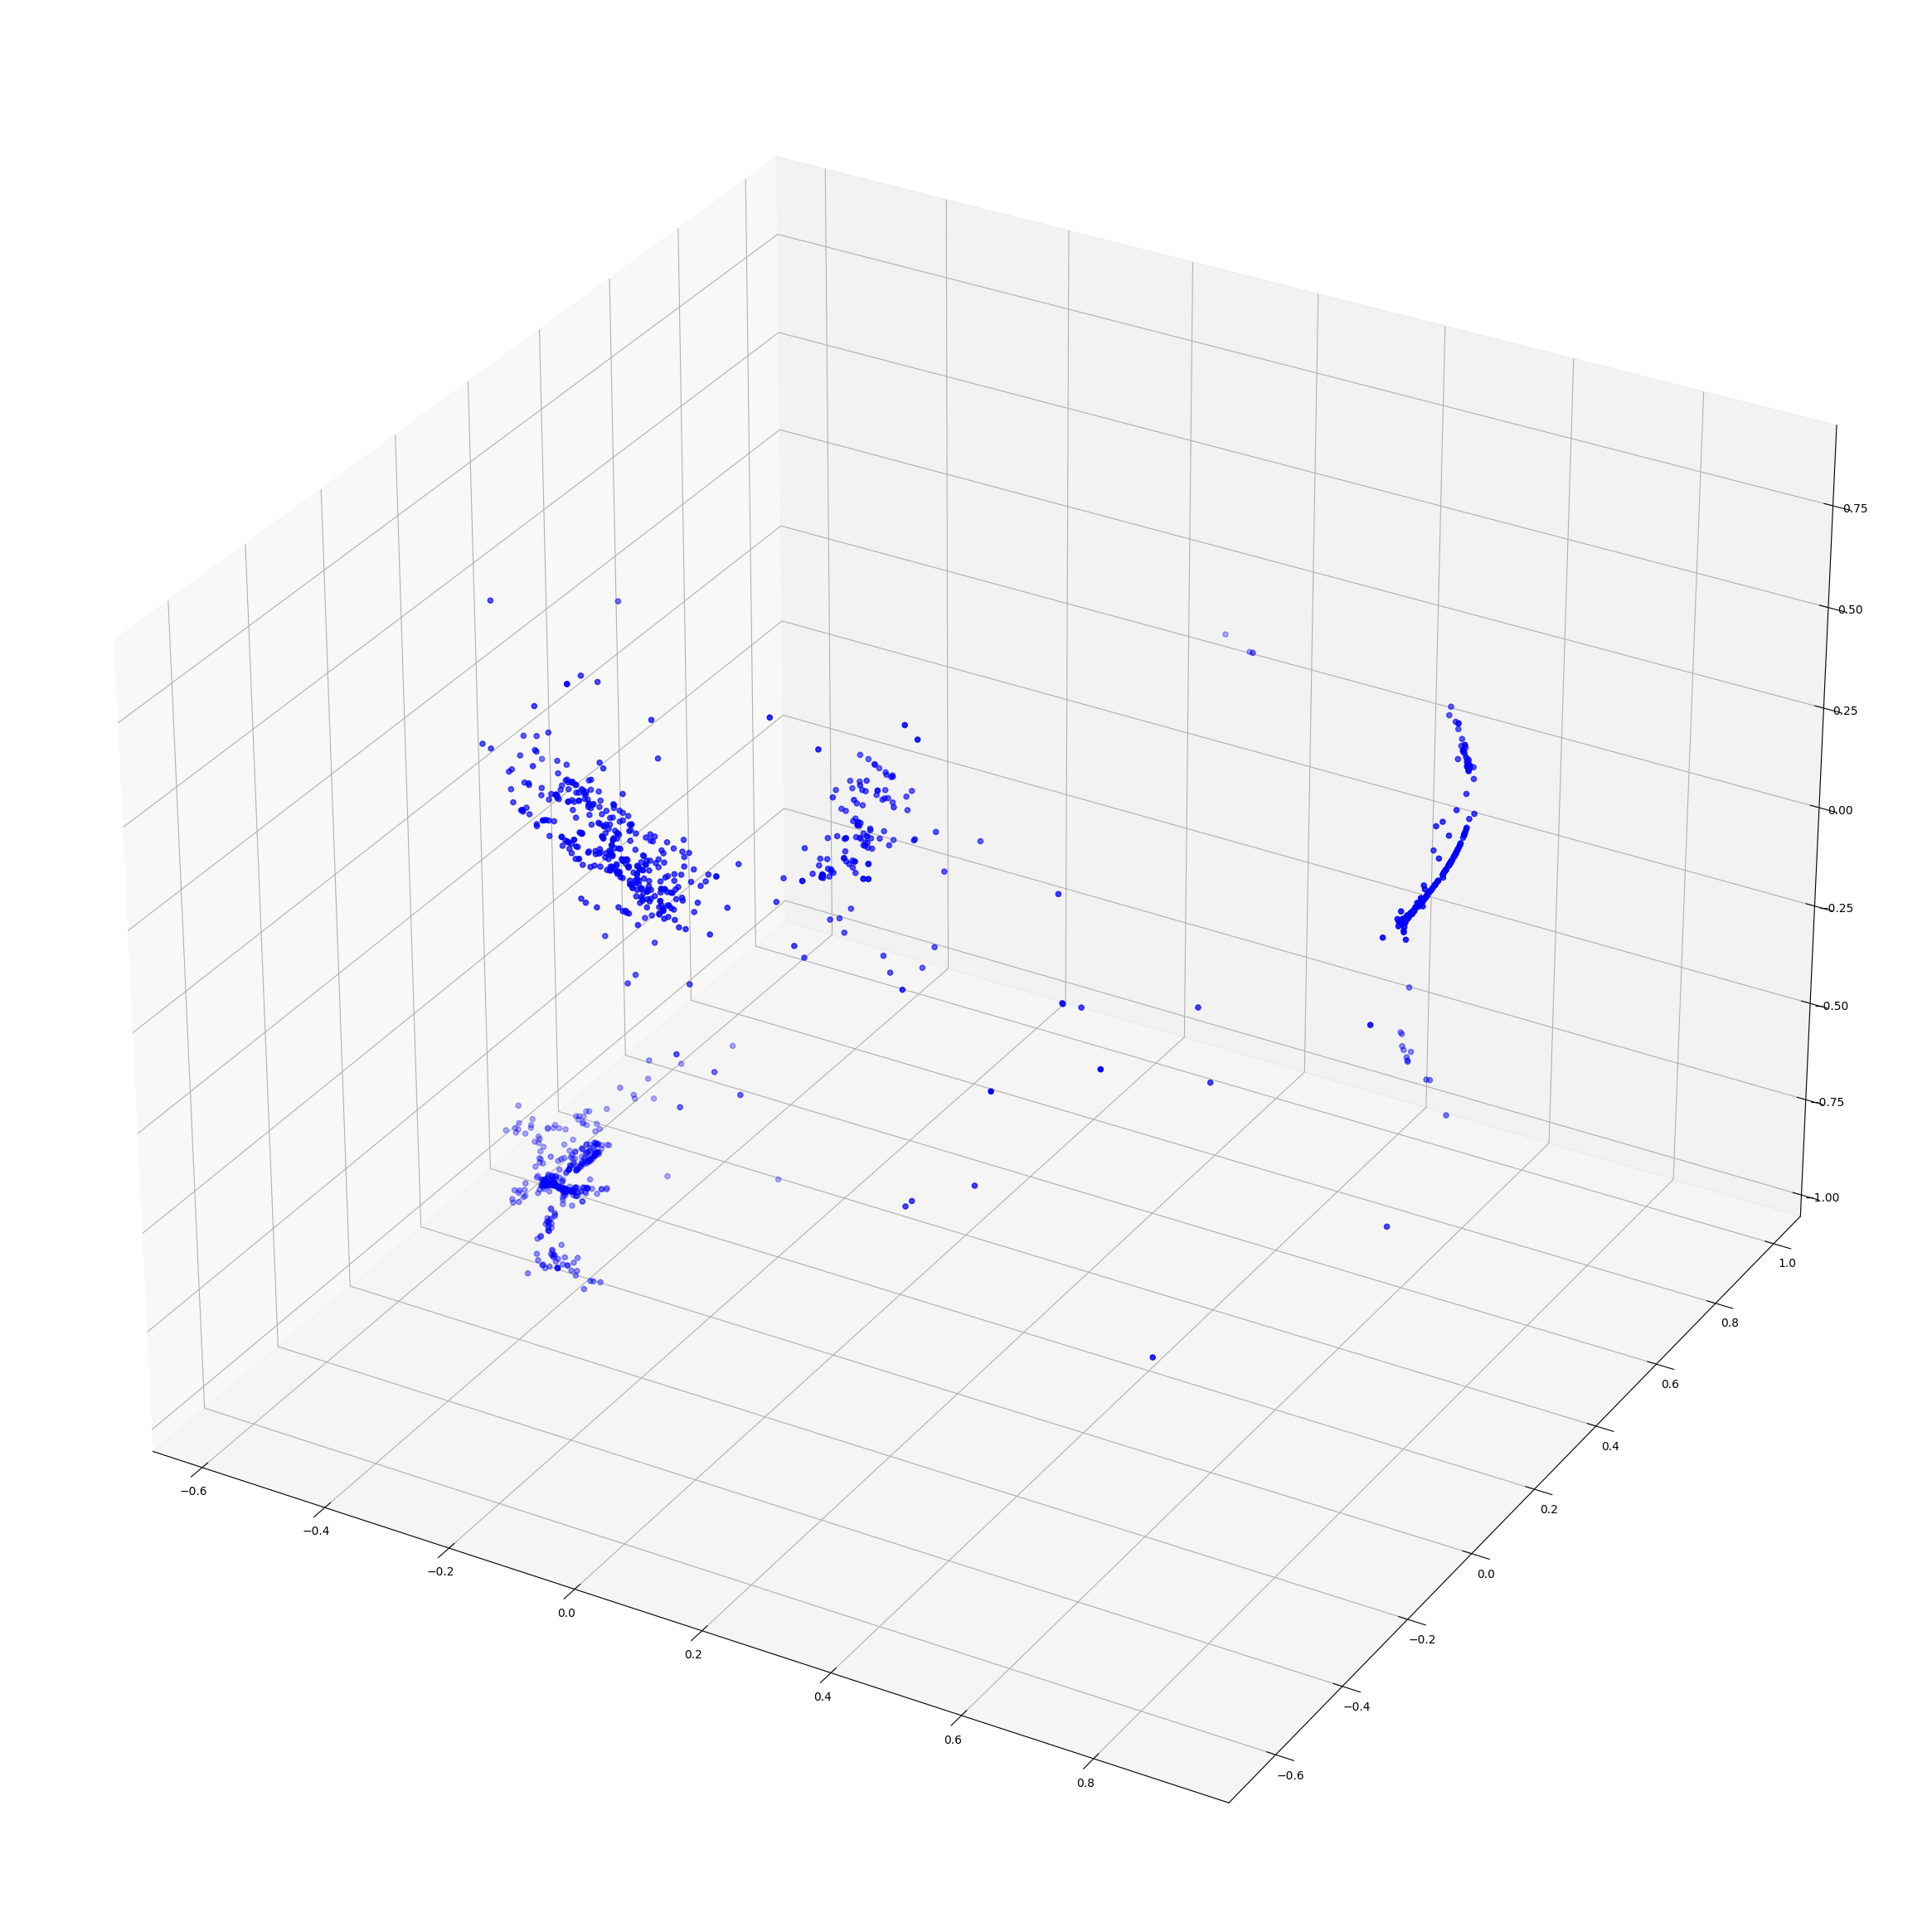

In [41]:
################################################################################################################################
# Step 3: Essential Matrix Decomposition & Step 4: Triangulation
################################################################################################################################
U, S, VT = np.linalg.svd(best_E, full_matrices=True)

W = np.array([[0.0, -1.0, 0.0],
              [1.0, 0.0, 0.0],
              [0.0, 0.0, 1.0]
              ])

P = np.array([
    np.column_stack((U @ W @ VT, U[:,2])),
    np.column_stack((U @ W @ VT, -U[:,2])),
    np.column_stack((U @ W.T @ VT, U[:,2])),
    np.column_stack((U @ W.T @ VT, -U[:,2]))])


print('candidate for camera matrix\n', P)

E_init = np.append(np.eye(3), np.zeros((3,1)), axis=1)
for i in range(4):
    tmp = P[i]
    for j in range(len(inlier_idx)):
        A = np.array([
            norm_q1[0,j+1]*E_init[2] - E_init[0].T,
            norm_q1[1,j+1]*E_init[2] - E_init[1].T,
            norm_q2[0,j+1]*tmp[2] - tmp[0].T,
            norm_q2[1,j+1]*tmp[2] - tmp[1].T])
        U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=True)
        X = VT_A[3]/VT_A[3,3]

        if X[2] > 0 and (tmp@X.T)[2]>0:
            print(f'Matrix {i} have all positive depths!')
            E = P[i]
            break
        else:
            print(f'Matrix {i} is not good')
            break

inlier_X = []
eig = np.linalg.eig
eig_arr = [0,0,0,0]

for i in range(len(inlier_idx)):
    A = np.array([
        norm_q1[0,i+1]*E_init[2].T - E_init[0].T,
        norm_q1[1,i+1]*E_init[2].T - E_init[1].T,
        norm_q2[0,i+1]*E[2].T - E[0].T,
        norm_q2[1,i+1]*E[2].T - E[1].T])
    U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=True)
    eig_arr = eig(VT_A)[0]
    X = VT_A[:,np.argmax(eig_arr)]

    inlier_X.append(X)
    
p3ds = np.array(inlier_X).T

# visualize
X = np.array([])
Y = np.array([])
Z = np.array([])
X = np.concatenate((X, p3ds[0]))
Y = np.concatenate((Y, p3ds[1]))
Z = np.concatenate((Z, p3ds[2]))

fig = plt.figure(figsize=(30,30))
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, c='b', marker='o') 
# plt.show()
plt.savefig('./results/3D_result.jpg')

In [ ]:
################################################################################################################################
# Step 5: Growing Steps
################################################################################################################################



# of matches: 12600
save keypoints: done
save matches: done


100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


# of inliers: 849
save Essential Matrix: done
candidate for camera matrix
 [[[ 0.92290462 -0.3182424   0.21672297  0.54504144]
  [ 0.36151093  0.90993209 -0.20330627  0.37487476]
  [-0.13250251  0.26598002  0.95482863  0.74993249]]

 [[ 0.92290462 -0.3182424   0.21672297 -0.54504144]
  [ 0.36151093  0.90993209 -0.20330627 -0.37487476]
  [-0.13250251  0.26598002  0.95482863 -0.74993249]]

 [[-0.33515956  0.71843617  0.60952238  0.54504144]
  [ 0.04273499 -0.6346823   0.77159063  0.37487476]
  [ 0.94119168  0.28465391  0.18201748  0.74993249]]

 [[-0.33515956  0.71843617  0.60952238 -0.54504144]
  [ 0.04273499 -0.6346823   0.77159063 -0.37487476]
  [ 0.94119168  0.28465391  0.18201748 -0.74993249]]]
Matrix 0 have all positive depths!
Matrix 1 is not good
Matrix 2 is not good
Matrix 3 is not good


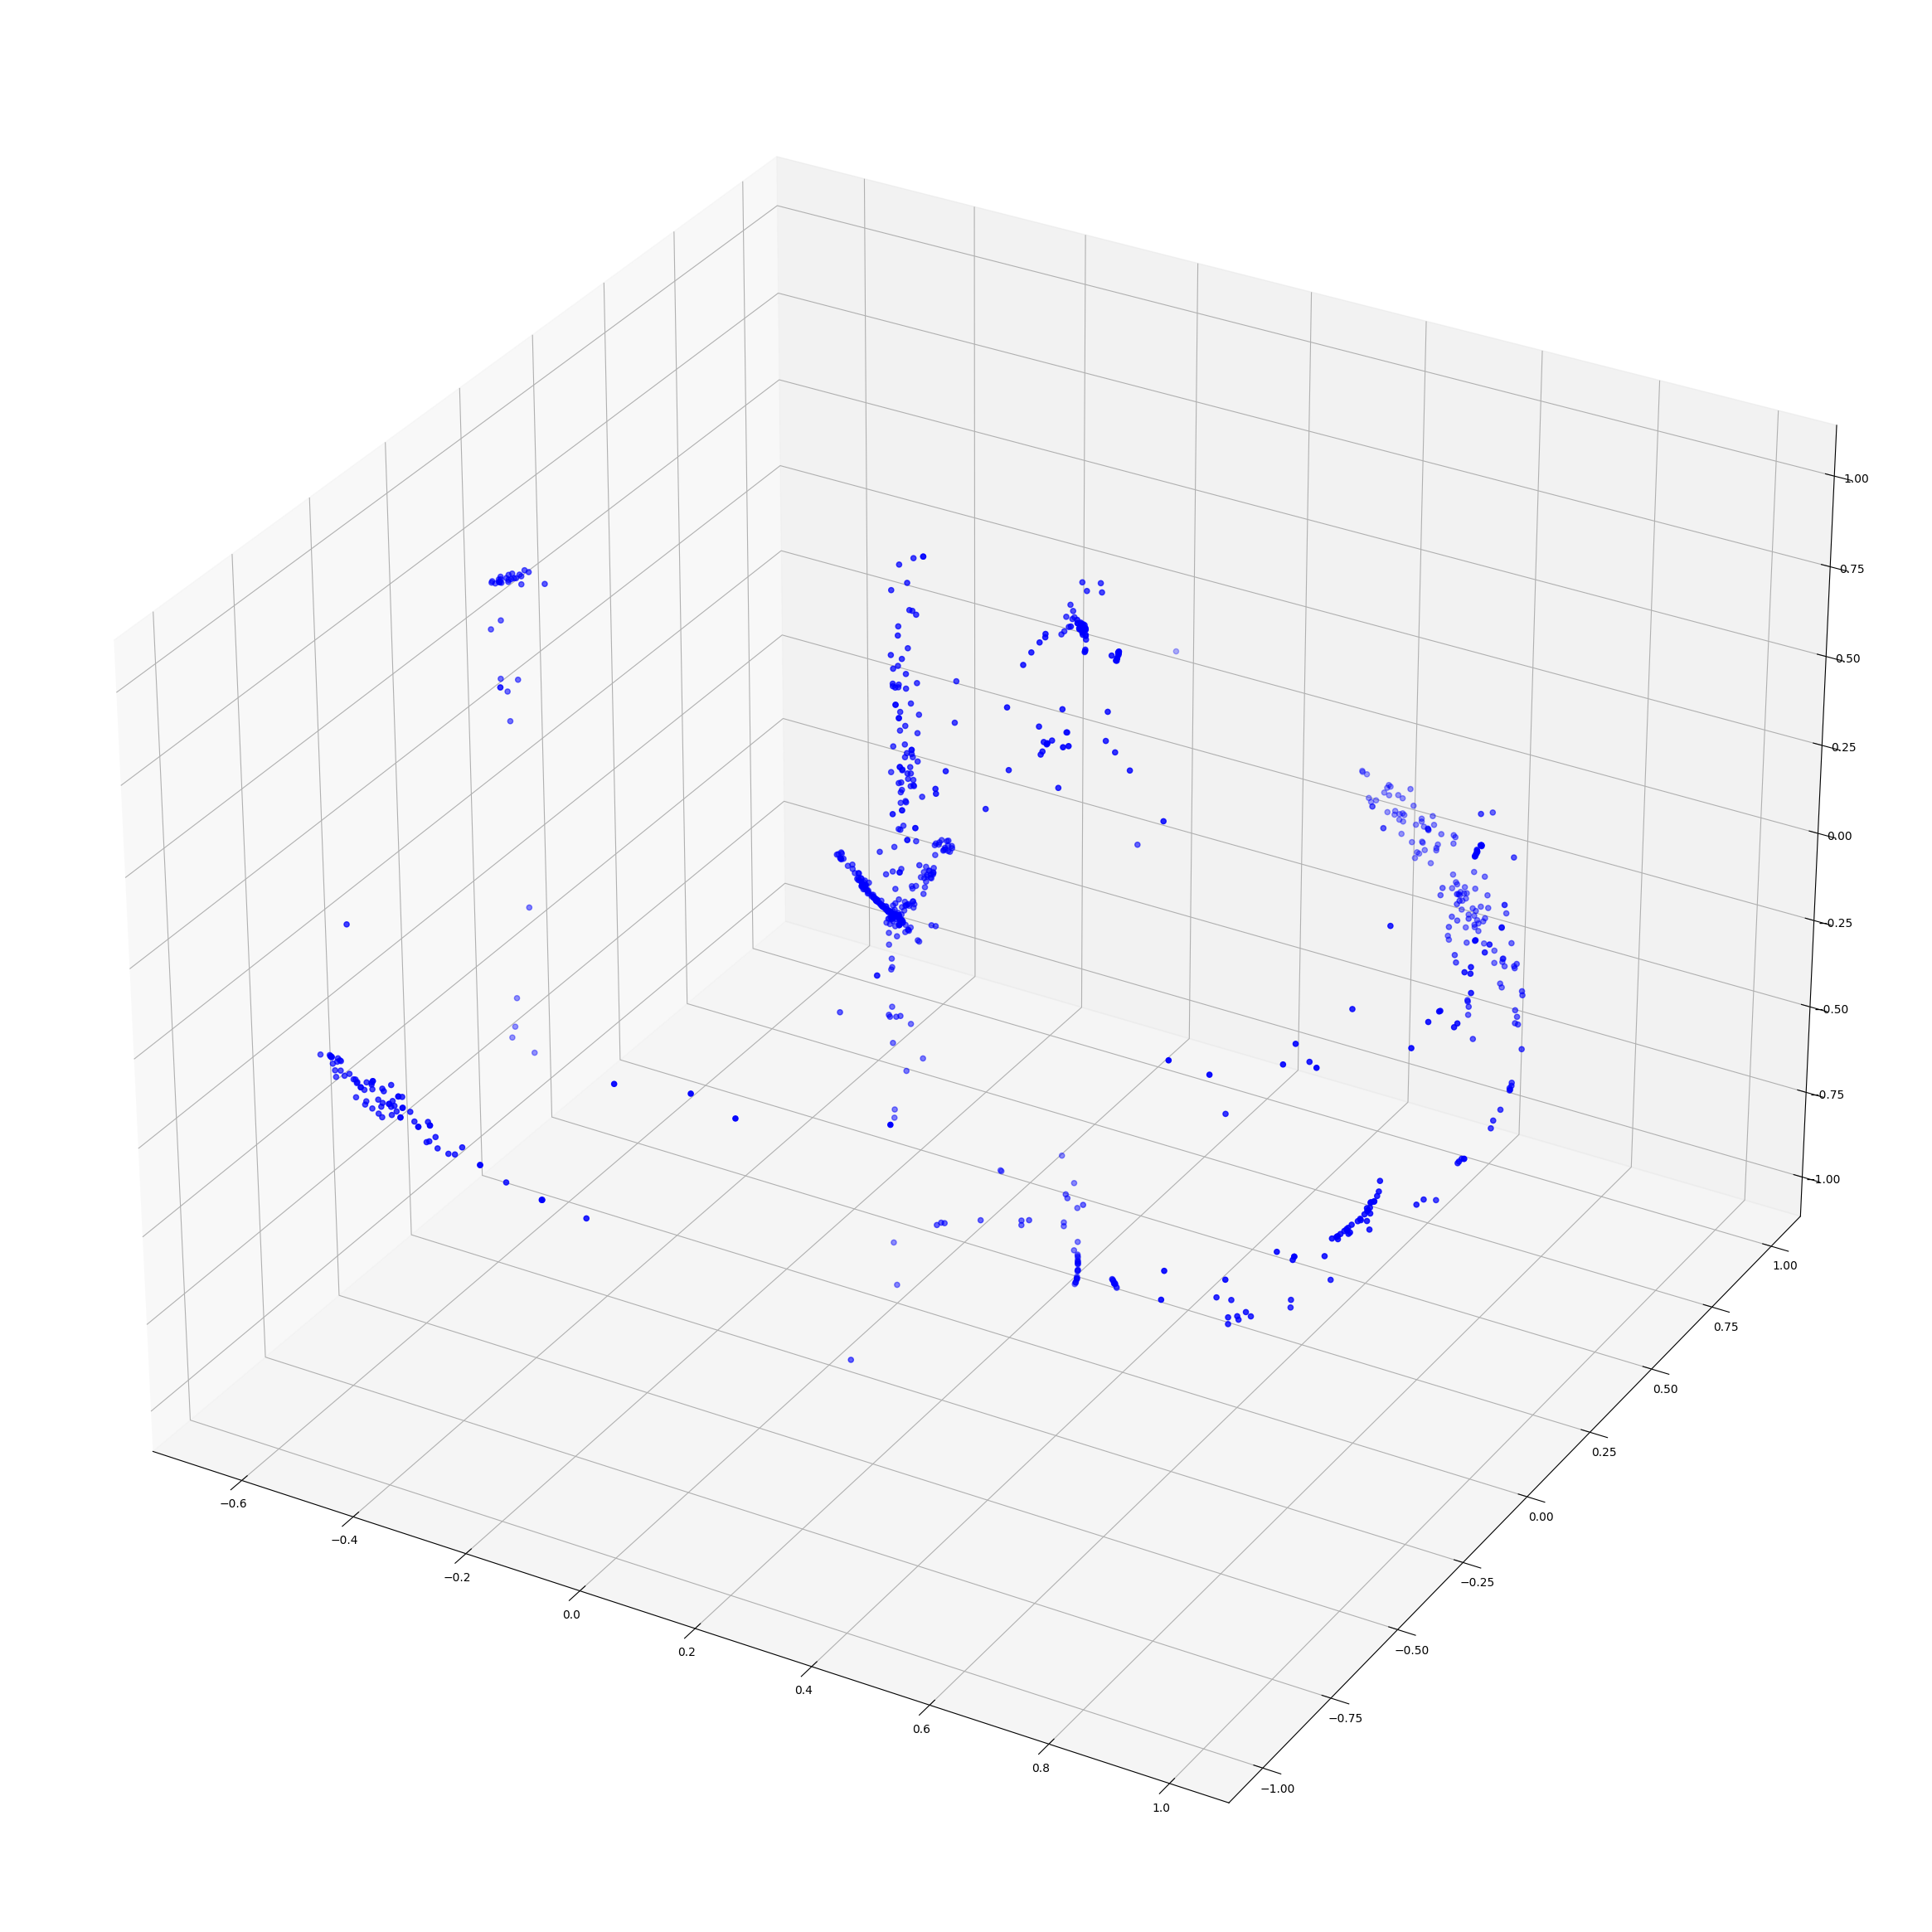

In [5]:
import numpy as np
import cv2 as cv

import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath("./SfM/Step2")  # 'calibrated_fivepoint.m'가 위치한 경로

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

################################################################################################################################
# Step 7: Camera Calibration
################################################################################################################################
corner_num = (6,8)
objpoints = []
imgpoints = []

# termination criteria
criteria = (2 + 1, 30, 0.001)

objpt = np.zeros((corner_num[1]*corner_num[0],3), np.float32)
objpt[:,:2] = np.mgrid[0:corner_num[0],0:corner_num[1]].T.reshape(-1,2)

images = glob.glob('./SfM/Step7/*.jpg')
for fname in tqdm(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    ret, corners = cv.findChessboardCorners(gray, corner_num, None)

    if ret == True:
        objpoints.append(objpt)
        corners_tuned = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners_tuned)

print(len(objpoints)==len(imgpoints))
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

MAXITER = 100
threshold = 5e-4

# intrinsic parameter
K = np.array(cameraMatrix)
K_inv = np.linalg.inv(K)

################################################################################################################################
# Step 1: Feature Extraction & Matching
################################################################################################################################
img1 = cv.imread('./SfM/Data/own/sfm_own_03.jpg')
img2 = cv.imread('./SfM/Data/own/sfm_own_04.jpg')

# create SIFT instance
sift = cv.SIFT_create()

# detect and compute keypoints
img1_kp, img1_des = sift.detectAndCompute(img1, None)
img2_kp, img2_des = sift.detectAndCompute(img2, None)

# Brute-force Matching
bf = cv.BFMatcher()
matches = bf.match(img1_des,img2_des)
 
 
sorted_good = sorted(matches, key = lambda x : x.distance)

print(f'# of matches: {len(sorted_good)}')

# save result as image
img1_drawKps = cv.drawKeypoints(img1, img1_kp, None)
img2_drawKps = cv.drawKeypoints(img2, img2_kp, None)
cv.imwrite('./results/own/sift_keypoints.jpg',img1_drawKps)
print('save keypoints: done')

res = cv.drawMatches(img1, img1_kp, img2, img2_kp, sorted_good, img2, flags=2) 
cv.imwrite('./results/own/sift_bfMatcher.jpg',res)
print('save matches: done')

################################################################################################################################
# Step 2: Essential Matrix Estimation
################################################################################################################################
query_idx = [good.queryIdx for good in sorted_good]
train_idx = [good.trainIdx for good in sorted_good]

kp1 = np.float32([img1_kp[idx].pt for idx in query_idx])
kp2 = np.float32([img2_kp[idx].pt for idx in train_idx])

ones = np.ones((1, len(kp1)))

q1 = np.append(kp1.T, ones, axis=0)
q2 = np.append(kp2.T, ones, axis=0)

norm_q1 = K_inv @ q1
norm_q2 = K_inv @ q2

best_in = 0
best_E = None

# 5-points algorithm / RANSAC
for _ in tqdm(range(MAXITER)):

    idx = np.random.randint(0, len(kp1), size=5)
    rand_norm_q1 = norm_q1[:, idx]
    rand_norm_q2 = norm_q2[:, idx]
    rand_norm_q1_doub = matlab.double(rand_norm_q1.tolist())
    rand_norm_q2_doub = matlab.double(rand_norm_q2.tolist())
    
    E = eng.calibrated_fivepoint(rand_norm_q1_doub, rand_norm_q2_doub)
    E = np.array(E)
    
    for i in range(E.shape[1]):
        cur_E = E[:,i].reshape(3,3)
        
        estim = np.diag(norm_q2.T @ cur_E @ norm_q1)
        cur_in = sum(np.where(((estim < threshold) & (estim >= 0)), True, False))
        if best_in < cur_in:
            best_in = cur_in
            best_E = cur_E
            inlier_idx = np.where(((estim < threshold) & (estim >= 0)))

      
print(f'# of inliers: {best_in}')
inlier_idx = np.array(inlier_idx).reshape(-1)

# save
df = pd.DataFrame(best_E)
df.to_csv('./results/own/EssentialMatrix.csv')
print('save Essential Matrix: done')

################################################################################################################################
# Step 3: Essential Matrix Decomposition & Step 4: Triangulation
################################################################################################################################
U, S, VT = np.linalg.svd(best_E, full_matrices=True)

W = np.array([[0.0, -1.0, 0.0],
              [1.0, 0.0, 0.0],
              [0.0, 0.0, 1.0]
              ])

P = np.array([
    np.column_stack((U @ W @ VT, U[:,2])),
    np.column_stack((U @ W @ VT, -U[:,2])),
    np.column_stack((U @ W.T @ VT, U[:,2])),
    np.column_stack((U @ W.T @ VT, -U[:,2]))])


print('candidate for camera matrix\n', P)

E_init = np.append(np.eye(3), np.zeros((3,1)), axis=1)
for i in range(4):
    tmp = P[i]
    for j in range(len(inlier_idx)):
        A = np.array([
            norm_q1[0,j+1]*E_init[2] - E_init[0].T,
            norm_q1[1,j+1]*E_init[2] - E_init[1].T,
            norm_q2[0,j+1]*tmp[2] - tmp[0].T,
            norm_q2[1,j+1]*tmp[2] - tmp[1].T])
        U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=True)
        X = VT_A[3]/VT_A[3,3]

        if X[2] > 0 and (tmp@X.T)[2]>0:
            print(f'Matrix {i} have all positive depths!')
            E = P[i]
            break
        else:
            print(f'Matrix {i} is not good')
            break

inlier_X = []
eig = np.linalg.eig
eig_arr = [0,0,0,0]

for i in range(len(inlier_idx)):
    A = np.array([
        norm_q1[0,i+1]*E_init[2].T - E_init[0].T,
        norm_q1[1,i+1]*E_init[2].T - E_init[1].T,
        norm_q2[0,i+1]*E[2].T - E[0].T,
        norm_q2[1,i+1]*E[2].T - E[1].T])
    U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=True)
    eig_arr = eig(VT_A)[0]
    X = VT_A[:,np.argmax(eig_arr)]

    inlier_X.append(X)
    
p3ds = np.array(inlier_X).T

# visualize
X = np.array([])
Y = np.array([])
Z = np.array([])
X = np.concatenate((X, p3ds[0]))
Y = np.concatenate((Y, p3ds[1]))
Z = np.concatenate((Z, p3ds[2]))

fig = plt.figure(figsize=(30,30))
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, c='b', marker='o') 
# plt.show()
plt.savefig('./results/own/3D_result.jpg')

In [5]:
import numpy as np
import cv2 as cv
import glob

import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath("./SfM/Step2")  # 'calibrated_fivepoint.m'가 위치한 경로

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

################################################################################################################################
# Step 7: Camera Calibration
################################################################################################################################
corner_num = (6,8)
objpoints = []
imgpoints = []

# termination criteria
criteria = (2 + 1, 30, 0.001)

objpt = np.zeros((corner_num[1]*corner_num[0],3), np.float32)
objpt[:,:2] = np.mgrid[0:corner_num[0],0:corner_num[1]].T.reshape(-1,2)

images = glob.glob('./PA2_Structure_from_Motion/SfM/Step7/*.jpg')

for fname in tqdm(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    ret, corners = cv.findChessboardCorners(gray, corner_num, None)

    if ret == True:
        objpoints.append(objpt)
        corners_tuned = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners_tuned)

print(len(objpoints)==len(imgpoints))
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# intrinsic parameter
K = np.array(cameraMatrix)
K_inv = np.linalg.inv(K)
T = np.array[[0.0, -tvecs[2], tvecs[1]],
             [tvecs[2], 0.0, -tvecs[0],
              -tvecs[1], tvecs[0], 0.0]
             ] 
R = rvecs
E = T@R

# ################################################################################################################################
# # Step 1: Feature Extraction & Matching
# ################################################################################################################################
img1 = cv.imread('./SfM/Data/own/sfm_own_03.jpg')
img2 = cv.imread('./SfM/Data/own/sfm_own_04.jpg')

# create SIFT instance
sift = cv.SIFT_create()

# detect and compute keypoints
img1_kp, img1_des = sift.detectAndCompute(img1, None)
img2_kp, img2_des = sift.detectAndCompute(img2, None)

# Brute-force Matching
bf = cv.BFMatcher()
matches = bf.match(img1_des,img2_des)
 
 
sorted_good = sorted(matches, key = lambda x : x.distance)

print(f'# of matches: {len(sorted_good)}')

# save result as image
img1_drawKps = cv.drawKeypoints(img1, img1_kp, None)
img2_drawKps = cv.drawKeypoints(img2, img2_kp, None)
cv.imwrite('./results/own/sift_keypoints.jpg',img1_drawKps)
print('save keypoints: done')

res = cv.drawMatches(img1, img1_kp, img2, img2_kp, sorted_good, img2, flags=2) 
cv.imwrite('./results/own/sift_bfMatcher.jpg',res)
print('save matches: done')

E_init = np.append(np.eye(3), np.zeros((3,1)), axis=1)
inlier_X = []
eig = np.linalg.eig
eig_arr = [0,0,0,0]

for i in range(len(inlier_idx)):
    A = np.array([
        norm_q1[0,i+1]*E_init[2].T - E_init[0].T,
        norm_q1[1,i+1]*E_init[2].T - E_init[1].T,
        norm_q2[0,i+1]*E[2].T - E[0].T,
        norm_q2[1,i+1]*E[2].T - E[1].T])
    U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=True)
    eig_arr = eig(VT_A)[0]
    X = VT_A[:,np.argmax(eig_arr)]

    inlier_X.append(X)
    
p3ds = np.array(inlier_X).T

# visualize
X = np.array([])
Y = np.array([])
Z = np.array([])
X = np.concatenate((X, p3ds[0]))
Y = np.concatenate((Y, p3ds[1]))
Z = np.concatenate((Z, p3ds[2]))

fig = plt.figure(figsize=(30,30))
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, c='b', marker='o') 
# plt.show()
plt.savefig('./results/own/3D_result.jpg')

0it [00:00, ?it/s]

True


NameError: name 'gray' is not defined